In [65]:
from scipy.io import wavfile
from main import GPU_VMD
import numpy as np
import matplotlib.pyplot as plt
import os
import vmdpy

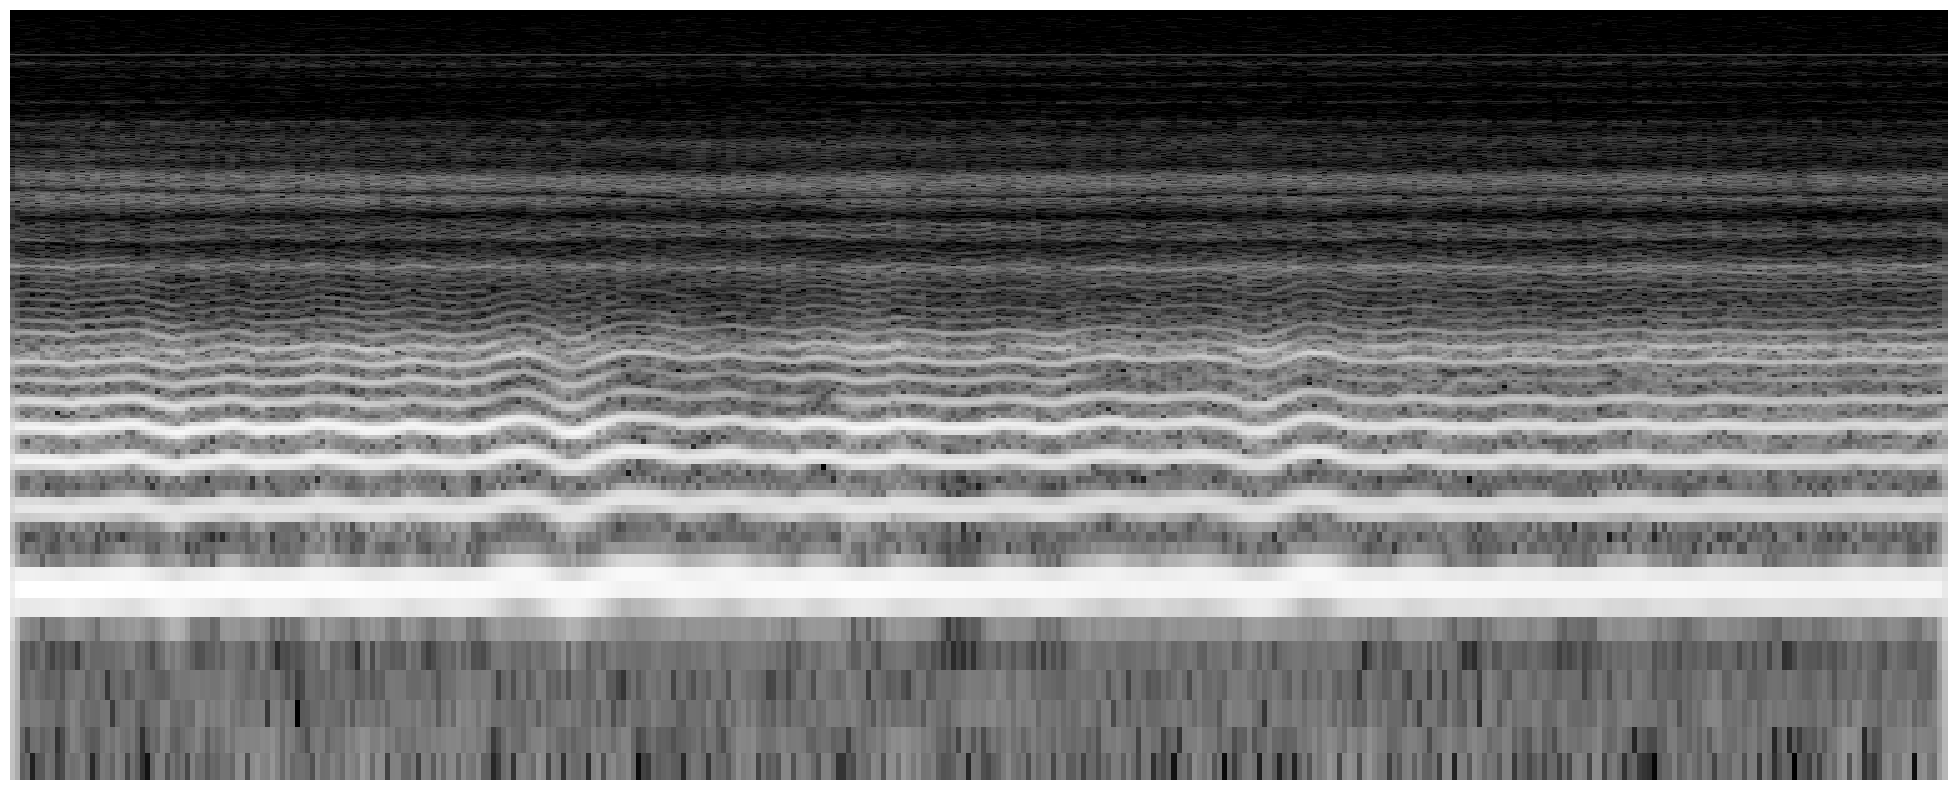

C:\Users\ganes\AppData\Local\Temp\ipykernel_7008\3710900678.py:24: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8').reshape(height, width, 3)


In [23]:

import librosa
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

# Load speech signal
signal, sr = librosa.load(r'../../Dataset/neurovoz_v3/data/audios/HC_A1_0034.wav', sr=None)

# Compute STFT
stft_result = librosa.stft(signal, n_fft=2048, hop_length=512)
# Compute magnitude
stft_magnitude = np.abs(stft_result)

fig = plt.figure(figsize=(25, 10))
librosa.display.specshow(librosa.amplitude_to_db(stft_magnitude, ref=np.max),
                         sr=sr, hop_length=512, y_axis='log', x_axis='time', cmap='gray')
plt.axis(False)
plt.show()

canvas = FigureCanvas(fig)
canvas.draw()

width, height = canvas.get_width_height()
image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8').reshape(height, width, 3)

plt.close(fig)


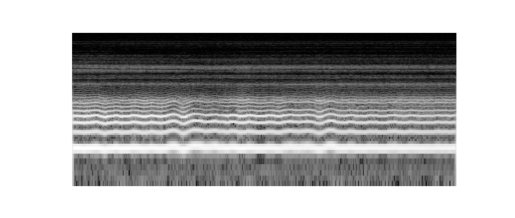

In [26]:
plt.imshow(image)
plt.axis(False);

In [66]:
# Initialize VMD
vmd = GPU_VMD(
    alpha=200000,
    tau=0,
    n_modes=8,
    dc_component=False,
    init_method=1,
    tolerance=1e-6,
    device='cuda'
)

In [ ]:

def vmd(signal, alpha=200000, tau=0, K=8, DC=0, init=1, tol=1e-6):
    print("VMD started")
    # Ensure signal is a numpy array
    signal = np.array(signal, dtype=np.float64)
    
    # Normalize the signal (optional)
    signal = signal / np.max(np.abs(signal))

    # Perform VMD
    modes, _, _ = vmdpy.VMD(signal, alpha, tau, K, DC, init, tol)
    print(modes.shape)
    # Reconstruct the signal from the modes
    reconstructed_signal = np.sum(modes, axis=0, dtype=np.float64)
    print(reconstructed_signal.shape)
    # Calculate residual (signal minus reconstructed signal)
    residual = signal - reconstructed_signal
    print("VMD completed")
    return modes, residual


In [68]:

def pad_signal(original: np.ndarray, reconstructed: np.ndarray) -> np.ndarray:
    """
    Pad or trim reconstructed signal to match original length.
    
    Parameters:
    -----------
    original : np.ndarray
        Original signal
    reconstructed : np.ndarray
        Reconstructed signal
        
    Returns:
    --------
    np.ndarray
        Padded/trimmed reconstructed signal
    """
    if len(reconstructed) < len(original):
        return np.pad(reconstructed, (0, len(original) - len(reconstructed)))
    return reconstructed[:len(original)]


In [69]:
def save_modes_and_reconstruct(modes, sample_rate, original_signal, base_filename, output_dir='processed_audio', exclude_modes=None):
    """
    Save the decomposed VMD modes and reconstructed signal.
    
    Parameters:
    -----------
    modes : numpy.ndarray
        The decomposed modes from VMD (shape: [n_modes, signal_length])
    sample_rate : int
        Sampling rate of the original audio
    original_signal : numpy.ndarray
        The original input signal
    base_filename : str
        Base filename to use for saving outputs
    output_dir : str
        Directory to save the output files (default: 'processed_audio')
    exclude_modes : list of int, optional
        Indices of modes to exclude from the reconstructed signal
    """
    # Create output directories if they don't exist
    modes_dir = os.path.join(output_dir, 'IMFs')
    plots_dir = os.path.join(output_dir, 'Plots')
    reconstructed_dir = os.path.join(output_dir, 'Reconstructed')
    
    for directory in [modes_dir, plots_dir, reconstructed_dir]:
        os.makedirs(directory, exist_ok=True)
    
    # Save individual modes as WAV files
    for i, mode in enumerate(modes):
        mode_filename = os.path.join(modes_dir, f"{base_filename}_mode_{i+1}.wav")
        # Normalize mode to prevent clipping
        normalized_mode = mode / np.max(np.abs(mode))
        wavfile.write(mode_filename, sample_rate, normalized_mode.astype(np.float32))
    
    # Reconstruct signal by summing all modes except the excluded ones
    if exclude_modes is None:
        reconstructed_signal = np.sum(modes, axis=0)
    else:
        reconstructed_signal = np.sum(modes[[i for i in range(len(modes)) if i not in exclude_modes]], axis=0)
    
    # Normalize reconstructed signal
    reconstructed_signal = reconstructed_signal / np.max(np.abs(reconstructed_signal))
    
    # Save reconstructed signal
    reconstructed_filename = os.path.join(reconstructed_dir, f"{base_filename}_reconstructed.wav")
    wavfile.write(reconstructed_filename, sample_rate, reconstructed_signal.astype(np.float32))
    
    # Create and save visualization plot
    plt.figure(figsize=(15, 10))
    
    # Plot original signal
    plt.subplot(modes.shape[0] + 2, 1, 1)
    plt.plot(original_signal)
    plt.title('Original Signal')
    plt.ylabel('Amplitude')
    
    # Plot individual modes
    for i, mode in enumerate(modes):
        plt.subplot(modes.shape[0] + 2, 1, i + 2)
        plt.plot(mode)
        plt.title(f'Mode {i+1}')
        plt.ylabel('Amplitude')
    
    # Plot reconstructed signal
    plt.subplot(modes.shape[0] + 2, 1, modes.shape[0] + 2)
    plt.plot(reconstructed_signal)
    plt.title('Reconstructed Signal')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    
    # Adjust layout and save plot
    plt.tight_layout()
    plot_filename = os.path.join(plots_dir, f"{base_filename}_analysis.png")
    plt.savefig(plot_filename)
    plt.close()
    
    # Calculate and return reconstruction error
    reconstruction_error = np.mean((original_signal - reconstructed_signal) ** 2)
    
    return reconstruction_error


In [70]:

# file_path = "../../Dataset/neurovoz_v3/data/audios/HC_A1_0034.wav"
# sample_rate, data = wavfile.read(file_path)
# print(min(data), max(data))

# if len(data.shape) == 2:
#     data = data[:, 0]
# #data = data / np.max(np.abs(data))

# # Decompose signal
# result = vmd.decompose(data)
# modes_gpu = result.modes


In [71]:
# save_modes_and_reconstruct(modes_gpu, sample_rate, data, 'HC_A1_0034', output_dir='')

In [72]:
# t = np.linspace(0, 1, len(data))

# plt.figure(figsize=(25, 18))

# plt.suptitle("Decomposed Modes: GPU-Accelerated VMD", fontsize=16)
# for i, mode in enumerate(modes_gpu):
#     plt.subplot(len(modes_gpu), 1, i + 1)
#     plt.plot(t, pad_signal(data, mode), label=f"GPU Mode {i+1}", color='green')
#     plt.legend()
#     plt.xlabel("Time")
#     plt.ylabel("Amplitude")
#     plt.grid(True)

# plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.show()

In [ ]:

file_path = "../../Dataset/neurovoz_v3/data/audios/HC_A1_0034.wav"
sample_rate, data = wavfile.read(file_path)
print(min(data), max(data))

if len(data.shape) == 2:
    data = data[:, 0]
data = data / np.max(np.abs(data))

# Decompose signal
result = vmd(data)
#modes_gpu = result.modes

-2038 2784
VMD started
(8, 197710)
(197710,)
VMD completed


AttributeError: 'tuple' object has no attribute 'modes'

In [74]:
modes_gpu, _ = result

In [75]:
save_modes_and_reconstruct(modes_gpu, sample_rate, data, 'HC_A1_0034', output_dir='', exclude_modes=[1])

0.10112546820913636

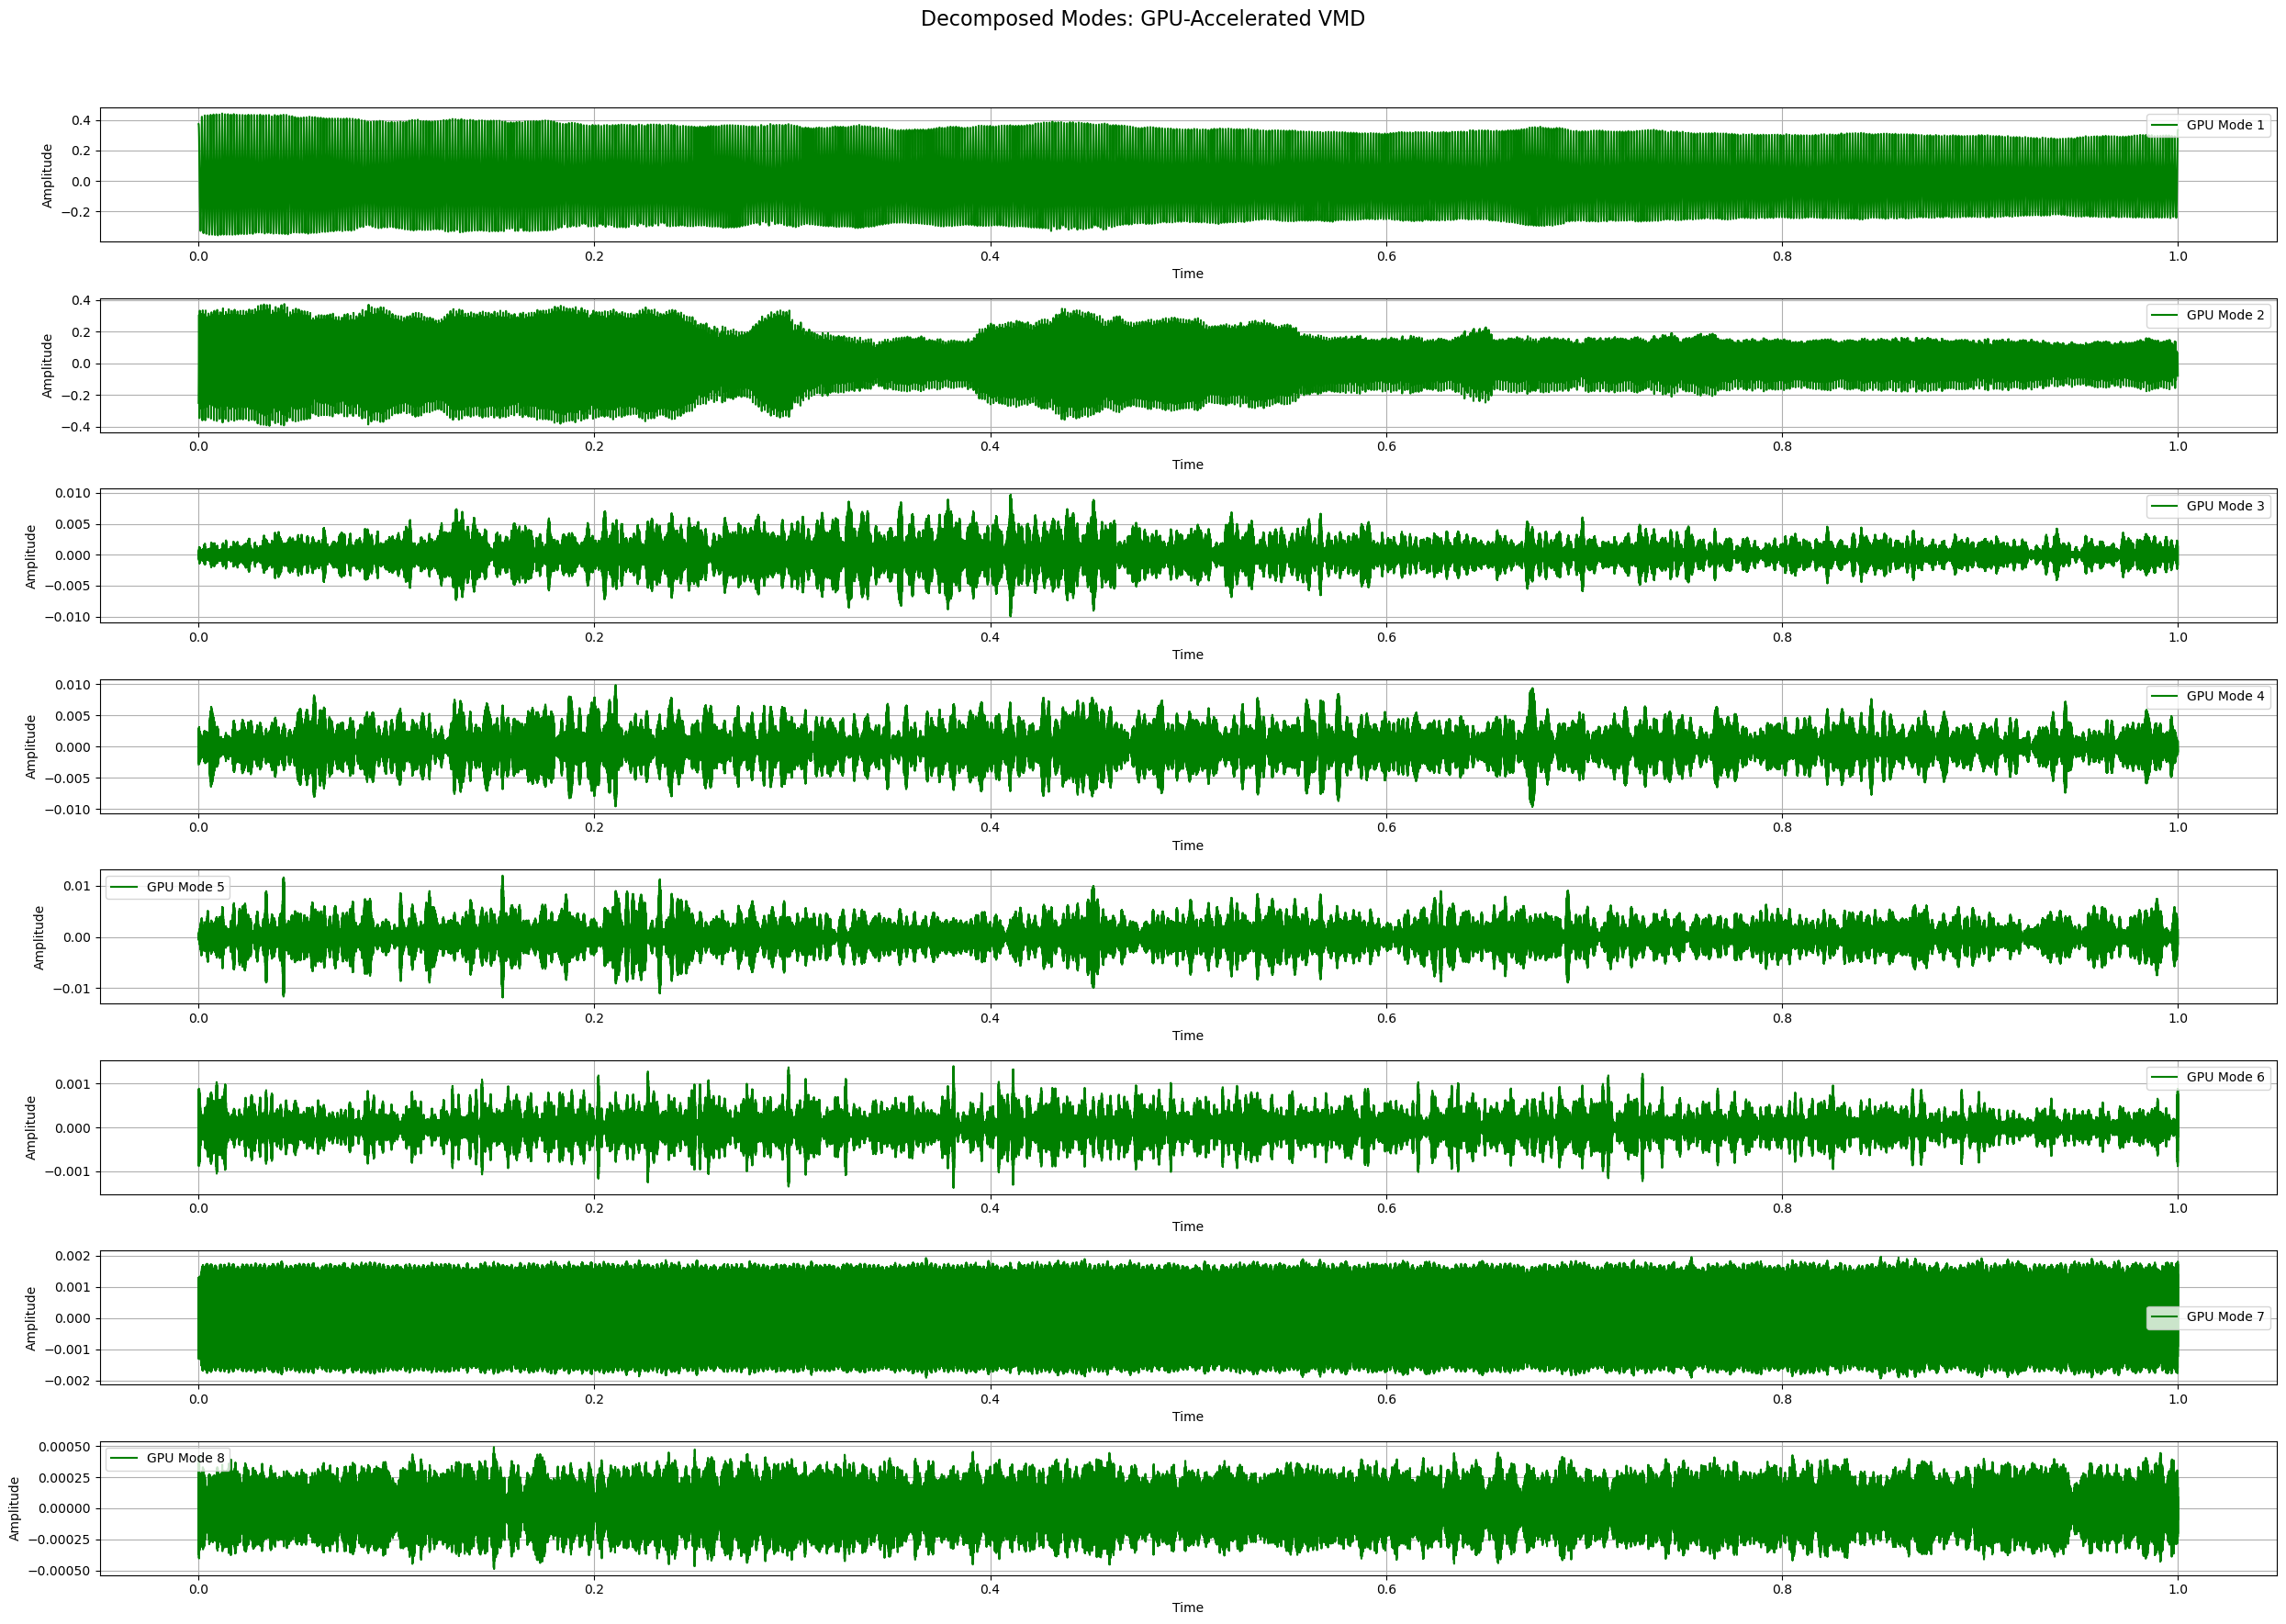

In [76]:
t = np.linspace(0, 1, len(data))

plt.figure(figsize=(25, 18))

plt.suptitle("Decomposed Modes: GPU-Accelerated VMD", fontsize=16)
for i, mode in enumerate(modes_gpu):
    plt.subplot(len(modes_gpu), 1, i + 1)
    plt.plot(t, pad_signal(data, mode), label=f"GPU Mode {i+1}", color='green')
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

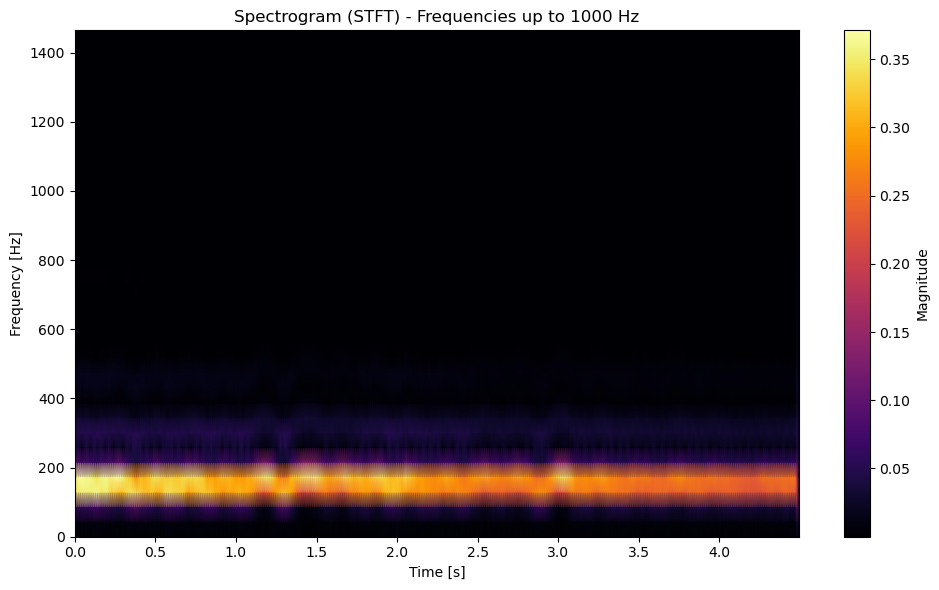

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import stft

# Step 1: Read the audio file
samplerate, data = wavfile.read('Reconstructed/HC_A1_0034_reconstructed.wav')

# Ensure the audio is mono (convert if necessary)
if data.ndim > 1:
    data = data.mean(axis=1)

# Step 2: Apply STFT
# Define parameters for STFT
nperseg = 1024  # Length of each segment
f, t, Zxx = stft(data, fs=samplerate, nperseg=nperseg)

# Step 3: Filter frequencies up to 1000 Hz
freq_limit = 1500
freq_indices = f <= freq_limit
f_filtered = f[freq_indices]
Zxx_filtered = Zxx[freq_indices, :]

# Step 4: Plot the spectrogram
plt.figure(figsize=(10, 6))
plt.pcolormesh(t, f_filtered, np.abs(Zxx_filtered), shading='gouraud', cmap='inferno')
plt.title('Spectrogram (STFT) - Frequencies up to 1000 Hz')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Magnitude')
plt.tight_layout()
plt.show()